In [2]:
import fastbox as fb
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.optimize import newton
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import pandas as pd
import seaborn as sns

In [3]:
import psutil
import os

print(u"Current process's memory usage：%.4f GB" % (psutil.Process(os.getpid()).memory_info().rss / 1024 ** 3) )

info = psutil.virtual_memory()
print(u'Total computer memory：%.4f GB' % (info.total / 1024 ** 3) )
print(u'Current percentage of total memory used：',info.percent)
print(u'Number of CPUs：',psutil.cpu_count())

Current process's memory usage：0.2824 GB
Total computer memory：63.9449 GB
Current percentage of total memory used： 18.6
Number of CPUs： 8


In [27]:
option_price = fb.data.indexoptions.daily(instrumentid = 'IO2112',from_date = '2021-6-01',to_date = '2021-6-01',complete = True)
index_price = fb.data.index.daily(instrumentid = '000300',from_date = '2021-6-01',to_date = '2021-6-01',complete = True).iloc[0,0]

In [34]:
mat=(option_price.index.get_level_values('maturity')[0]-option_price.index.get_level_values('date')[0]).days

In [35]:
# Parameters
# simulation dependent
S0 = index_price          # asset price
T = mat/360                # time in years
r = 0.02               # risk-free rate
N = 252                # number of time steps in simulation
M = 1000               # number of simulations
# Heston dependent parameters
kappa = 3              # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # long-term mean of variance under risk-neutral dynamics
v0 = 0.25**2           # initial variance under risk-neutral dynamics
rho = 0.7              # correlation between returns and variances under risk-neutral dynamics
sigma = 0.6            # volatility of volatility

(0.04000000000000001, 0.0625)

In [36]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M):
    """
    Inputs:
     - S0, v0: initial parameters for asset and variance
     - rho   : correlation between asset returns and variance
     - kappa : rate of mean reversion in variance process
     - theta : long-term mean of variance process
     - sigma : vol of vol / volatility of variance process
     - T     : time of simulation
     - N     : number of time steps
     - M     : number of scenarios / simulations
    
    Outputs:
    - asset prices over time (numpy array)
    - variance over time (numpy array)
    """
    # initialise other parameters
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])
    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)
    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))
    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)
    
    return S, v

In [37]:
rho_p = 0.98
rho_n = -0.98
S_p,v_p = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma,T, N, M)
S_n,v_n = heston_model_sim(S0, v0, rho_n, kappa, theta, sigma,T, N, M)

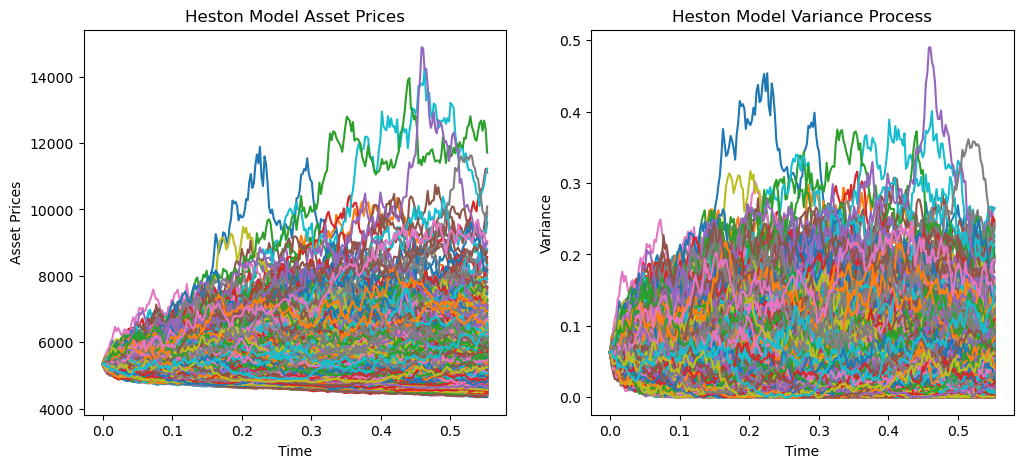

In [38]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0,T,N+1)
ax1.plot(time,S_p)
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')
ax2.plot(time,v_p)
ax2.set_title('Heston Model Variance Process')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')
plt.show()

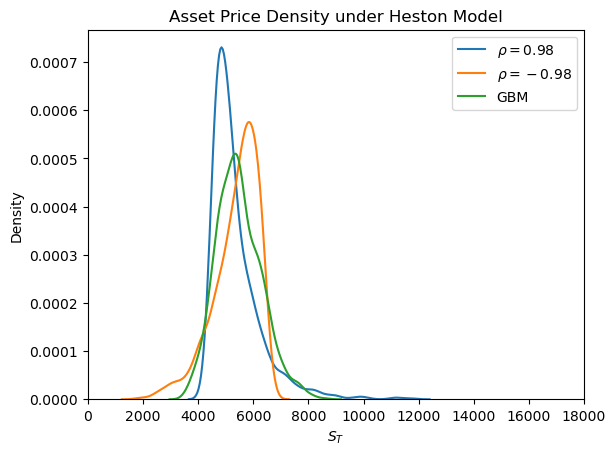

In [40]:
# simulate gbm process at time T
gbm = S0*np.exp( (r - theta**2/2)*T + np.sqrt(theta)*np.sqrt(T)*np.random.normal(0,1,M) )
fig, ax = plt.subplots()
ax = sns.kdeplot(S_p[-1], label=r"$\rho= 0.98$", ax=ax)
ax = sns.kdeplot(S_n[-1], label=r"$\rho= -0.98$", ax=ax)
ax = sns.kdeplot(gbm, label="GBM", ax=ax)
plt.title(r'Asset Price Density under Heston Model')
plt.xlim([0, 18000])
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.legend()
plt.show()